In [ ]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Manage_data.db_manager import get_data


In [15]:
symbols_dict = {
    'tech_symbols' : [
        "AAPL",   # Apple Inc.
        "NVDA",   # Nvidia Corporation
        "MSFT",   # Microsoft Corporation
        "GOOGL",  # Alphabet Inc. (classe A)
        "AMZN",   # Amazon.com Inc.
        "META",   # Meta Platforms Inc.
        "TSLA",   # Tesla Inc.
        "AVGO",   # Broadcom Inc.
        "TCEHY",  # Tencent Holdings Ltd.
        "TSM"     # Taiwan Semiconductor Manufacturing Company
    ],

    'commodities_symbols' : [
        "GC=F",   # Or (Gold) - utilisé pour les semi-conducteurs et connecteurs électroniques
        "SI=F",   # Argent (Silver) - utilisé dans les circuits imprimés et batteries
        "HG=F",   # Cuivre (Copper) - essentiel pour le câblage et les cartes mères
        #"AL=F",   # Aluminium (Aluminum) - utilisé dans la fabrication des boîtiers d’ordinateurs et de smartphones
        "PL=F",   # Platine (Platinum) - utilisé dans certains composants électroniques et piles à combustible
        "PA=F",   # Palladium (Palladium) - essentiel pour la fabrication de capteurs et composants électroniques
        #"LMCADS03=GB",  # Cobalt (Cobalt) - indispensable pour les batteries lithium-ion
        #"LTHM",   # Lithium (Lithium) - essentiel pour les batteries des véhicules électriques et smartphones
        #"FEF=F",  # Minerai de fer (Iron Ore) - utilisé dans la construction d’équipements et de serveurs
        #"ZNCADS03=GB"   # Zinc (Zinc) - utilisé pour le revêtement anticorrosion et certains alliages électroniques
    ],

    'telecom_symbols' : [
        "T",      # AT&T Inc.
        "VZ",     # Verizon Communications Inc.
        "TMUS",   # T-Mobile US, Inc.
        "CSCO",   # Cisco Systems, Inc.
        "NOK",    # Nokia Corporation
        #"ERIC",   # Ericsson (Telefonaktiebolaget LM Ericsson)
        "QCOM",   # Qualcomm Incorporated
        #"CHL",    # China Mobile Limited
        "NTTYY",  # Nippon Telegraph and Telephone Corporation (NTT)
        #"ORAN"    # Orange S.A.
    ]
}

all_symbols = [symbol for category in symbols_dict.values() for symbol in category]
print(all_symbols)

['AAPL', 'NVDA', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'AVGO', 'TCEHY', 'TSM', 'GC=F', 'SI=F', 'HG=F', 'PL=F', 'PA=F', 'T', 'VZ', 'TMUS', 'CSCO', 'NOK', 'QCOM', 'NTTYY']


In [16]:
df = get_data(all_symbols, granularity='daily')
df.head()

Adding Symbol: AAPL
entry already exists or no title
Adding Symbol: NVDA
entry already exists or no title
Adding Symbol: MSFT
entry already exists or no title
Adding Symbol: GOOGL
entry already exists or no title
Adding Symbol: AMZN
entry already exists or no title
Adding Symbol: META
entry already exists or no title
Adding Symbol: TSLA
entry already exists or no title
Adding Symbol: AVGO
entry already exists or no title
Adding Symbol: TCEHY
entry already exists or no title
Adding Symbol: TSM
entry already exists or no title
Adding Symbol: GC=F
entry already exists or no title
Adding Symbol: SI=F
entry already exists or no title
Adding Symbol: HG=F
entry already exists or no title
Adding Symbol: PL=F
entry already exists or no title
Adding Symbol: PA=F
entry already exists or no title
Adding Symbol: T
entry already exists or no title
Adding Symbol: VZ
entry already exists or no title
Adding Symbol: TMUS
entry already exists or no title
Adding Symbol: CSCO
entry already exists or no tit

,Title,Date,Open,High,Low,Close,Adj_close,Volume
0,META,2025-02-28,658.04,669.63,642.60,668.20,668.20,17517800.0
1,META,2025-02-27,682.45,688.65,657.57,658.24,658.24,12500000.0
2,META,2025-02-26,659.65,683.01,658.00,673.70,673.70,14488700.0
3,META,2025-02-25,665.97,668.00,641.86,657.50,657.50,20579700.0
4,META,2025-02-24,686.28,687.27,662.45,668.13,668.13,15677000.0


In [17]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def test_stationarity_per_stock(data, var='Adj_close'):
    """
    Teste la stationnarité pour chaque action (Title) en utilisant le test ADF.
    
    :param data: DataFrame avec au moins les colonnes ['Title', 'Date', 'Close']
    """
    results = []

    data["Date"] = pd.to_datetime(data["Date"])
    
    data = data.sort_values(by=["Title", "Date"])

    for title, group in data.groupby("Title"):
        close_prices = group[var].values
        result = adfuller(close_prices, autolag='AIC')
        p_value = result[1]

        results.append({
            "Title": title,
            "ADF Statistic": result[0],
            "p-value": p_value,
            "Stationary": p_value < 0.05  #si p < 0.05, la série est stationnaire
        })

    results_df = pd.DataFrame(results)
    return results_df

df.dropna(inplace=True)
test_stationarity_per_stock(df)


,Title,ADF Statistic,p-value,Stationary
0,AAPL,1.305367,0.996639,False
1,AMZN,0.499340,0.984853,False
2,AVGO,4.022765,1.000000,False
3,CSCO,0.156817,0.969733,False
4,GC=F,0.683641,0.989506,False
5,GOOGL,0.662318,0.989055,False
6,HG=F,-1.693855,0.434281,False
7,META,1.521698,0.997603,False
8,MSFT,1.330018,0.996772,False
9,NOK,-3.432320,0.009905,True


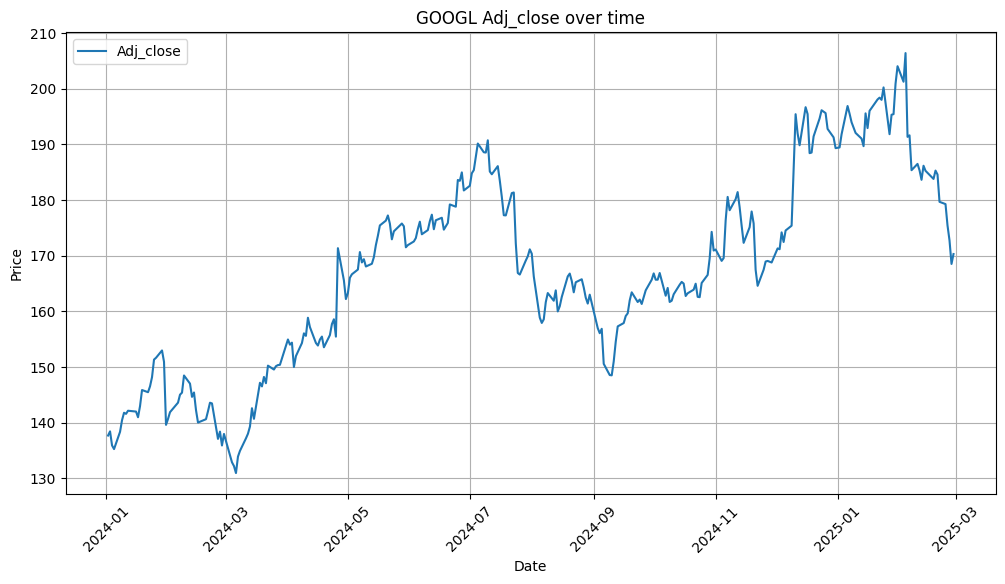

In [18]:

def plot_stock(df, title, columns='Adj_close', begin_y=2024):
    df_test = df[df['Title'] == title].copy()
    df_test = df_test[df_test["Date"].dt.year >= begin_y]
    plt.figure(figsize=(12, 6))

    for col in columns:
        plt.plot(df_test["Date"], df_test[col], linestyle="-", label=col)
        plt.title(f"{title} {col} over time")

    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

    del df_test

#columns = [col for col in df.select_dtypes(include=['float'])]
columns = ['Adj_close']#'Volume', 

plot_stock(df, 'GOOGL', columns=columns)


In [19]:
for var in df.columns:
    if var in ['Date', 'Title']: continue
    df[var] = df.groupby('Title')[var].pct_change()

df.dropna(inplace=True)


In [20]:
test_stationarity_per_stock(df)

,Title,ADF Statistic,p-value,Stationary
0,AAPL,-20.319404,0.000000e+00,True
1,AMZN,-62.836236,0.000000e+00,True
2,AVGO,-23.732600,0.000000e+00,True
3,CSCO,-22.519647,0.000000e+00,True
4,GC=F,-63.321892,0.000000e+00,True
5,GOOGL,-20.784154,0.000000e+00,True
6,HG=F,-23.325347,0.000000e+00,True
7,META,-19.011370,0.000000e+00,True
8,MSFT,-21.730445,0.000000e+00,True
9,NOK,-27.674585,0.000000e+00,True


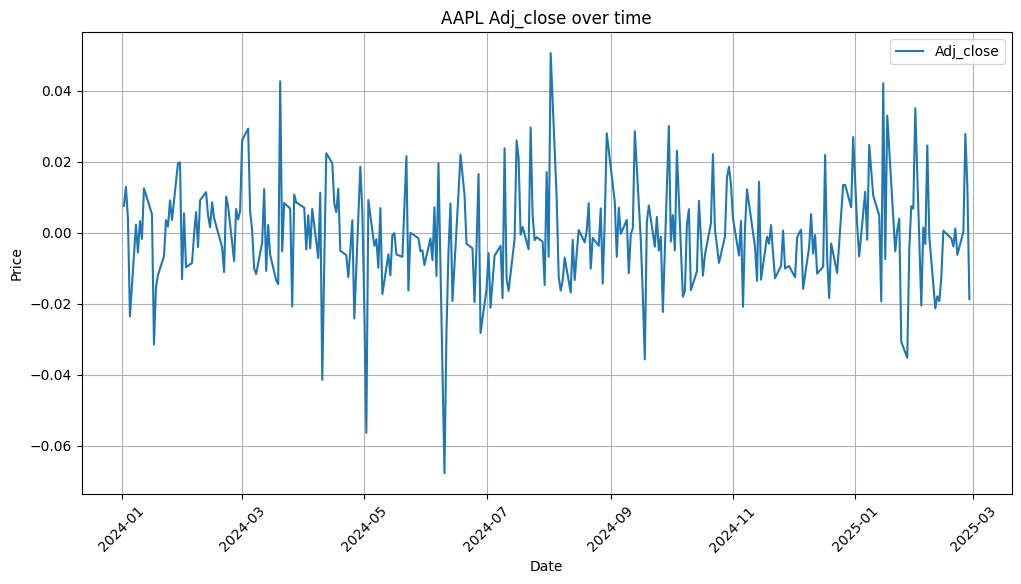

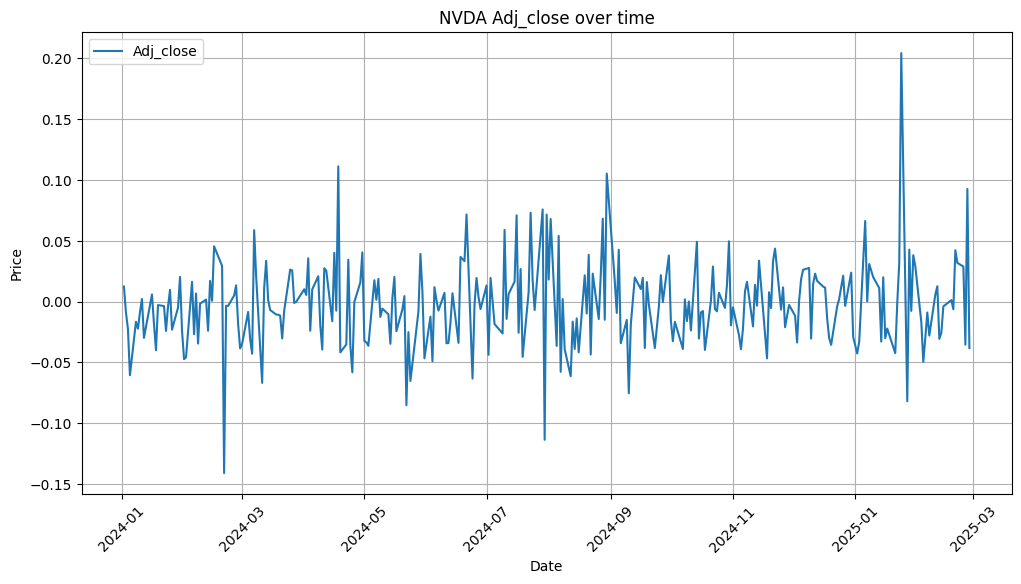

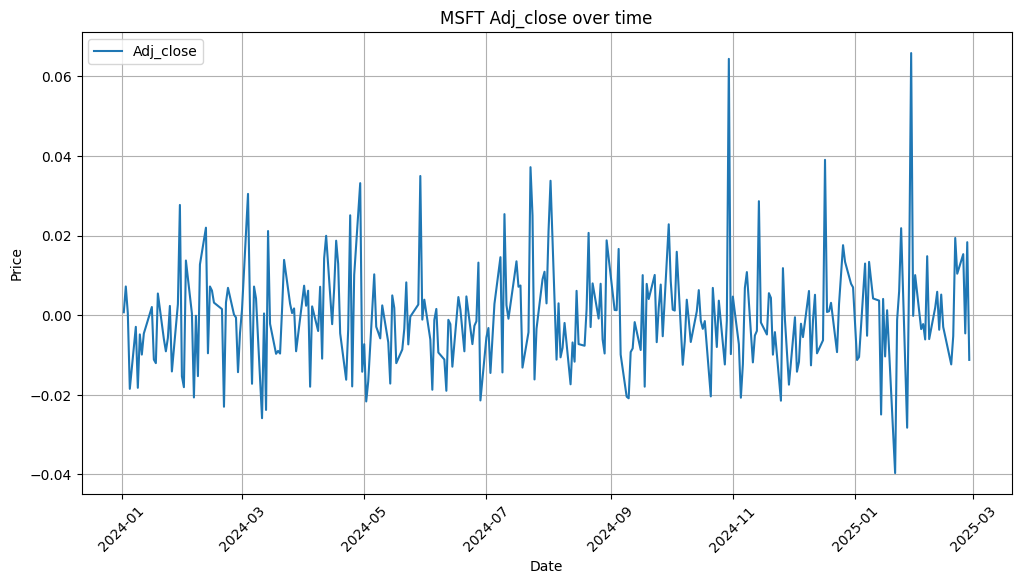

In [21]:
for symbol in all_symbols[:3]:
    plot_stock(df, symbol, columns=columns)

/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/ts

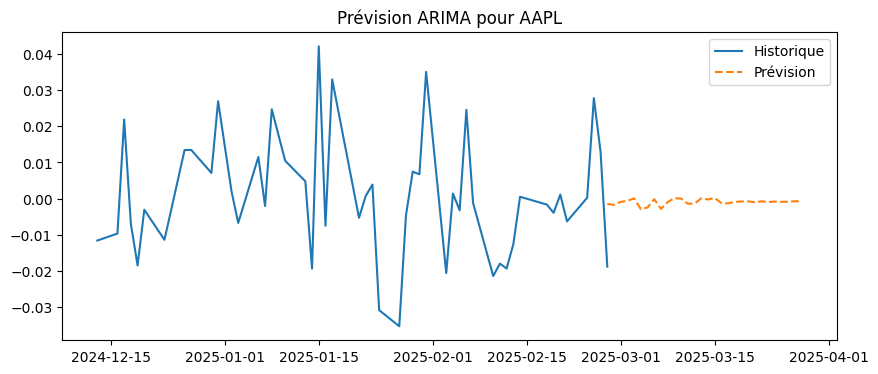

/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/ts

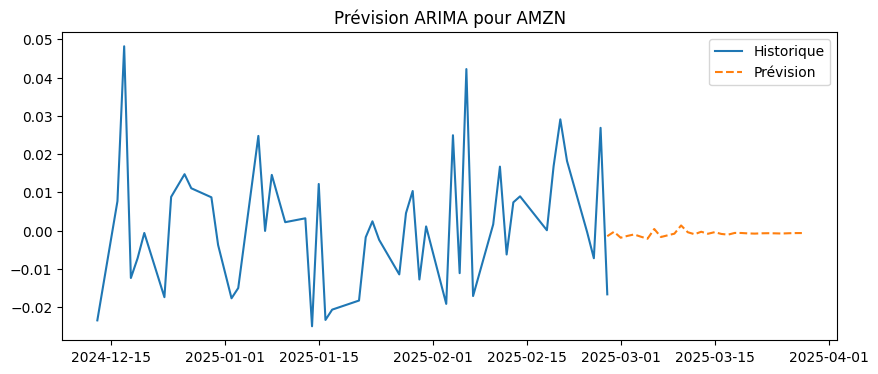

/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/ts

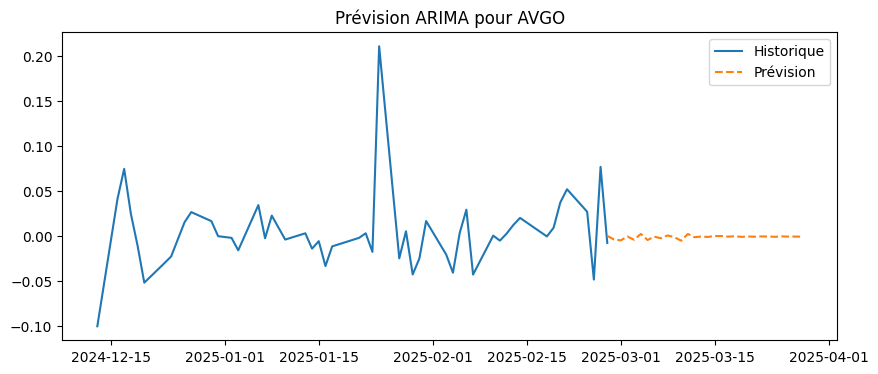

            AAPL  AMZN  AVGO
2025-02-27   NaN   NaN   NaN
2025-02-28   NaN   NaN   NaN
2025-03-01   NaN   NaN   NaN
2025-03-02   NaN   NaN   NaN
2025-03-03   NaN   NaN   NaN
2025-03-04   NaN   NaN   NaN
2025-03-05   NaN   NaN   NaN
2025-03-06   NaN   NaN   NaN
2025-03-07   NaN   NaN   NaN
2025-03-08   NaN   NaN   NaN
2025-03-09   NaN   NaN   NaN
2025-03-10   NaN   NaN   NaN
2025-03-11   NaN   NaN   NaN
2025-03-12   NaN   NaN   NaN
2025-03-13   NaN   NaN   NaN
2025-03-14   NaN   NaN   NaN
2025-03-15   NaN   NaN   NaN
2025-03-16   NaN   NaN   NaN
2025-03-17   NaN   NaN   NaN
2025-03-18   NaN   NaN   NaN
2025-03-19   NaN   NaN   NaN
2025-03-20   NaN   NaN   NaN
2025-03-21   NaN   NaN   NaN
2025-03-22   NaN   NaN   NaN
2025-03-23   NaN   NaN   NaN
2025-03-24   NaN   NaN   NaN
2025-03-25   NaN   NaN   NaN
2025-03-26   NaN   NaN   NaN
2025-03-27   NaN   NaN   NaN
2025-03-28   NaN   NaN   NaN


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

df.sort_values(by=['Title', 'Date'], inplace=True)

forecast_results = {}

for title in df['Title'].unique()[:3]:
    df_title = df[df['Title'] == title].set_index('Date')
    series = df_title['Adj_close'].dropna()
    
    model = sm.tsa.ARIMA(series, order=(20, 0, 2))
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=30)
    forecast_index = pd.date_range(start=series.index[-1], periods=30, freq=pd.infer_freq(series.index))
    
    forecast_results[title] = pd.Series(forecast, index=forecast_index)
    
    plt.figure(figsize=(10, 4))
    plt.plot(series[-50:], label='Historique')
    plt.plot(forecast_index, forecast, label='Prévision', linestyle='dashed')
    plt.title(f"Prévision ARIMA pour {title}")
    plt.legend()
    plt.show()

forecast_df = pd.DataFrame(forecast_results)
print(forecast_df)

# /!\ Problème de step?


In [27]:
forecast_index

DatetimeIndex(['2025-03-02', '2025-03-09', '2025-03-16', '2025-03-23',
               '2025-03-30', '2025-04-06', '2025-04-13', '2025-04-20',
               '2025-04-27', '2025-05-04', '2025-05-11', '2025-05-18',
               '2025-05-25', '2025-06-01', '2025-06-08', '2025-06-15',
               '2025-06-22', '2025-06-29', '2025-07-06', '2025-07-13',
               '2025-07-20', '2025-07-27', '2025-08-03', '2025-08-10',
               '2025-08-17', '2025-08-24', '2025-08-31', '2025-09-07',
               '2025-09-14', '2025-09-21'],
              dtype='datetime64[ns]', freq='W-SUN')

Train size: 2570, Test size: 643


/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/ndubourg/Documents/Cours/Master2/MLFi/projetfi/venv/lib64/python3.12/site-packages/statsmodels/ts


📊 Performance du modèle ARIMA sur le test set:
MAE: 0.0169, MSE: 0.0007, RMSE: 0.0272


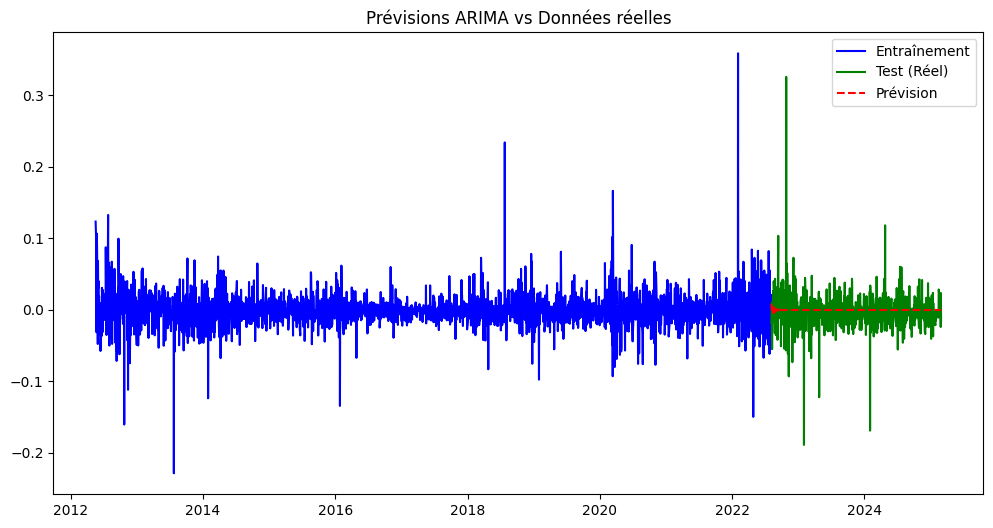

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_meta = df[df['Title'] == 'META'].copy()
df_meta['Date'] = pd.to_datetime(df_meta['Date'])
df_meta = df_meta.sort_values(by='Date').set_index('Date')

train_size = int(len(df_meta) * 0.8)

train, test = df_meta.iloc[:train_size], df_meta.iloc[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

order = (20, 0, 2)
model = ARIMA(train['Adj_close'], order=order)
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))
test['Forecast'] = forecast.values

mae = mean_absolute_error(test['Adj_close'], test['Forecast'])
mse = mean_squared_error(test['Adj_close'], test['Forecast'])
rmse = np.sqrt(mse)

print(f"\n📊 Performance du modèle ARIMA sur le test set:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(train['Adj_close'], label="Entraînement", color='blue')
plt.plot(test['Adj_close'], label="Test (Réel)", color='green')
plt.plot(test['Forecast'], label="Prévision", linestyle="dashed", color='red')
plt.title("Prévisions ARIMA vs Données réelles")
plt.legend()
plt.show()


In [24]:
df[df['Title'] == 'GOOGL'].head()

,Title,Date,Open,High,Low,Close,Adj_close,Volume
10839,GOOGL,2010-01-04,-0.000637,0.002546,0.004502,0.003841,0.004499,-0.348953
10838,GOOGL,2010-01-05,0.002554,0.003193,0.025049,0.026281,0.025709,-0.244804
10837,GOOGL,2010-01-06,0.026885,0.025540,0.022927,0.023537,0.024308,-0.379714
10836,GOOGL,2010-01-07,0.029710,0.011258,0.006106,-0.013271,-0.013324,0.357725
10835,GOOGL,2010-01-08,-0.021150,-0.001983,-0.008742,0.001995,0.001334,-0.345021


In [25]:
# df["Date"] = df["Date"].dt.strftime("%Y/%-m/%-d 0:00")
# df = df.rename(columns={"Date": "date"})
# df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
# df = df.pivot_table(index="date", columns="Title", values="Adj_close")
# df = df.rename(columns={"META":"OT"})


# # df["Volume"] = df["Volume"].astype(float)

# for var in df.columns:
#     if var in ['date', 'Title']: continue
#     df[var] = df[var].pct_change()

# df.dropna(inplace=True)


In [26]:
# dataset_dir = "../dataset/stock_var"
# os.makedirs(dataset_dir, exist_ok=True)
# csv_path = os.path.join(dataset_dir, "stock.csv")
# df.to_csv(csv_path, index=True)
# df.to_csv()